In [1]:
!pip install wordcloud -q
!pip install autocorrect -q
!pip install nltk -q
!pip install tqdm -q


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.metrics.distance import jaccard_distance, edit_distance
from autocorrect import Speller
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
from nltk.tokenize import TweetTokenizer
import numpy as np
from tqdm.notebook import tqdm
# customregexes.py contains all the regex functions used for all parts
from customregexes import *
tqdm.pandas()

In [3]:
nltk.download("stopwords")
nltk.download("words")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
df_data = pd.read_csv('A1_dataset.csv')

In [5]:
df_data

,LABEL,DATE_TIME,TEXT
0,0,Fri Jun 05 14:26:50 2009,About to get threaded and scared
1,1,Thu May 14 10:13:55 2009,@awaisnaseer I like Shezan Mangooo too!!! I ha...
2,1,Fri Jun 05 21:02:20 2009,worked on my car after work. showering then go...
3,1,Sun Jun 14 22:25:52 2009,@Marama Actually we start this afternoon! I w...
4,1,Sun May 31 00:42:12 2009,@gfalcone601 Aww Gi.don't worry.we'll vote for...
...,...,...,...
4282,1,Sat Jun 06 22:45:26 2009,@QandQ My performances on my CLEP tests. #qshock
4283,0,Tue Jun 16 10:17:07 2009,"ugh no, rcn had all the true blood episodes on..."
4284,1,Fri May 01 22:00:42 2009,Just returned from the forest! Sarah (my merch...
4285,1,Sun Jun 07 02:09:46 2009,is proud of her dad and his piece of work. ( h...


# I. REGULAR EXPRESSION

# A.

## a. Average number of sentences and tokens 
- ! or ? (Even Continous)
- . Followed by one or more spaces and then a capital character

In [6]:
df_data['sentence_count'] = df_data['TEXT'].apply(lambda x: findSentenceCount(x))

In [7]:
df_data.groupby(['LABEL'])['sentence_count'].mean()

LABEL
0    1.800500
1    1.854832
Name: sentence_count, dtype: float64

In [8]:
df_data['token_count'] = df_data['TEXT'].apply(lambda x: findTokenCount(x))

In [9]:
df_data['tokens'] = df_data['TEXT'].apply(lambda x: findTokens(x))

In [10]:
df_data.groupby(['LABEL'])['token_count'].mean()

LABEL
0    14.801000
1    14.116747
Name: token_count, dtype: float64

## b. Total number of words starting with consonants and vowels
- Words starting with either Consonant or Vowel (depending on subpart) followed by either an alphabet, an accented alphabet, an apostrophe or a hyphen.
- This was done to ensure no cases of say spanish text which creep in twitter data from countries like the U.S. are not missed


In [11]:
df_data['words_starting_with_vowel'] = df_data['TEXT'].apply(lambda x: countWordsStartingWithVowel(x))

In [12]:
df_data['words_starting_with_vowel'].sum()

14177

In [13]:
df_data.groupby(['LABEL'])['words_starting_with_vowel'].sum()

LABEL
0    6989
1    7188
Name: words_starting_with_vowel, dtype: int64

In [14]:
df_data['words_starting_with_consonant'] = df_data['TEXT'].apply(lambda x: countWordsStartingWithConsonant(x))

In [15]:
df_data['words_starting_with_consonant'].sum()

37196

In [16]:
df_data.groupby(['LABEL'])['words_starting_with_consonant'].sum()

LABEL
0    17995
1    19201
Name: words_starting_with_consonant, dtype: int64

## c. Lowercase the text and report the number of unique tokens present before and after lower casing.

Unique Tokens Before Splitting

In [17]:
def get_unique_tokens(tokens):
    unique_tokens = set()
    for token_list in tokens:
        for token in token_list:
            unique_tokens.add(token)
    return len(unique_tokens)

Total

In [18]:
tokens = df_data['tokens'].to_list()
df_data['lowercase_text'] = df_data['TEXT'].apply(lambda x: lowercase(x))
df_data['lowercase_tokens'] = df_data['lowercase_text'].apply(lambda x: findTokens(x))
lowercase_tokens = df_data['lowercase_tokens'].to_list()

In [19]:
print("Unique Tokens", get_unique_tokens(tokens))
print("Unique Lowercase Tokens", get_unique_tokens(lowercase_tokens))

Unique Tokens 13159
Unique Lowercase Tokens 11556


Label 0

In [20]:
tokens_LABEL_0 = df_data[df_data['LABEL'] == 0]['tokens'].to_list()
lowercase_tokens_LABEL_0 = df_data[df_data['LABEL'] == 0]['lowercase_tokens'].to_list()

In [21]:
print("Unique Tokens", get_unique_tokens(tokens_LABEL_0))
print("Unique Lowercase Tokens", get_unique_tokens(lowercase_tokens_LABEL_0))

Unique Tokens 6987
Unique Lowercase Tokens 6210


Label 1

In [22]:
tokens_LABEL_1 = df_data[df_data['LABEL'] == 1]['tokens'].to_list()
lowercase_tokens_LABEL_1 = df_data[df_data['LABEL'] == 1]['lowercase_tokens'].to_list()

In [23]:
print("Unique Tokens", get_unique_tokens(tokens_LABEL_1))
print("Unique Lowercase Tokens", get_unique_tokens(lowercase_tokens_LABEL_1))

Unique Tokens 8617
Unique Lowercase Tokens 7610


## d. Count and list all the usernames.

Basic Rules and Assumptions:

- According to [Twitter Guidelines](https://help.twitter.com/en/managing-your-account/twitter-username-rules)
  - Your username cannot be longer than 15 characters. Your name can be longer (50 characters) or shorter than 4 characters, but usernames are kept shorter for the sake of ease.
  - A username can only contain alphanumeric characters (letters A-Z, numbers 0-9) with the exception of underscores, as noted above. Check to make sure your desired username doesn't contain any symbols, dashes, or spaces.
  - *Optional Rule to Spot Users* - Usernames containing the words Twitter or Admin cannot be claimed. No account names can contain Twitter or Admin unless they are official Twitter accounts.

- Some experimentation with our Twitter Handle helped us reach the following conclusions:
  - @UserName can't be placed with other alphanumeric characters so abc@user 9@user are not valid and won't tag the user
  - X@UserName where X is a punctuation is valid but the following cases also don't allow tagging - 
    - @@xyz
    - _@xyz

Hence we propose regexes which actually find real tag matches instead of say a user just writing an @ somewhere in the tweet and it getting falsely matched as a tagged user when it really isn't

In [24]:
df_data['UserNames'] = df_data['TEXT'].apply(lambda x: findUsernames(x))
df_data['UserNamesCounts'] = df_data['TEXT'].apply(lambda x: findUsernameCount(x))

In [25]:
df_data['UserNamesCounts'].sum()

2108

In [26]:
print("Username Count Label 0 - " , df_data[df_data['LABEL'] == 0]['UserNamesCounts'].sum())

Username Count Label 0 -  803


In [27]:
print("Username Count Label 1 - " , df_data[df_data['LABEL'] == 1]['UserNamesCounts'].sum())

Username Count Label 1 -  1305


In [28]:
usernames = df_data['UserNames'].to_numpy()
flattened_usernames = []
for i in usernames:
  flattened_usernames.extend(i)

In [29]:
len(set(flattened_usernames))

2021

## e. Count and list all the urls

Basic Rules and Assumptions

- `http`, `https`, `www` common starters for URLs usually
- Manually investigating all sentences which contain `http` shows no false positives that is all occurences of `http` correspond to links
- Manually investigating all sentences which contain `www` shows lots of false positives due to words like `aww`
- On manual inspection we find no sentences which contain `https`
- According to [Twitter's official Blog](https://help.twitter.com/en/using-twitter/url-shortener), Twitter uses a URL-Shortener which converts links to the form `t.co` however there are no positive matches for this in our dataset. The only matches that arise are spurious matches in links like `blogspot.com`
- A URL maybe as simple as `www.xyz.abc` and as complex as `http://www.xyz.abc/efg` and can get even more complex by adding / to index more indepth into pages
- There are false positives that we encounter such as `Gi.don` or `worry.we` but they are both valid URLs as well as there can be custom domains by those names. We assume the domain will be atleast 2 characters long to account for `.me`, `.uk` etc.
- Numbers have been allowed as [only numbers can form valid URLs](https://stackoverflow.com/q/56804936/13858953)

In [30]:
df_data['URLs'] = df_data['TEXT'].apply(lambda x: findURLs(x))
df_data['URLCounts'] = df_data['TEXT'].apply(lambda x: findURLCount(x))

In [31]:
print("URL Count Label 0 - " , df_data[df_data['LABEL'] == 0]['URLCounts'].sum())

URL Count Label 0 -  60


In [32]:
print("URL Count Label 1 - " , df_data[df_data['LABEL'] == 1]['URLCounts'].sum())

URL Count Label 1 -  145


## f. Count the number of tweets for each day of the week. Eg Mon: 58, Tues: 20, Wed...

In [33]:
df_data['Day'] = df_data['DATE_TIME'].apply(lambda x: getDay(x))

In [34]:
print("Day Counts Label 0")
df_data[df_data['LABEL'] == 0]['Day'].value_counts()

Day Counts Label 0


Sun    565
Fri    473
Mon    391
Thu    171
Tue    154
Wed    127
Sat    119
Name: Day, dtype: int64

In [35]:
print("Day Counts Label 1")
df_data[df_data['LABEL'] == 1]['Day'].value_counts()

Day Counts Label 1


Sun    763
Mon    481
Fri    391
Sat    298
Wed    172
Tue    132
Thu     50
Name: Day, dtype: int64

In [36]:
df_data.to_csv('Save_post_regular_exp_section.csv')

# B.

## a. Total number of occurrences of the given word and sentences containing that word.

In [37]:
def re_find_word_in_sentence(word, sentence):
  return len(re.findall(f'\\b{word}\\b', sentence))

In [38]:
def find_word_counts(df_data, word, class_label):
  filtered_df = df_data[df_data['LABEL'] == class_label]
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_word_in_sentence(word, x))
  total_occurence = sum(filtered_df['Counts'])
  sentences_containing_word = filtered_df[filtered_df['Counts'] > 0]['TEXT'].to_list()
  return total_occurence, sentences_containing_word

In [39]:
total_occurence, sentences_containing_word = find_word_counts(df_data, 'i', 0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15532\4136765138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_word_in_sentence(word, x))


In [40]:
total_occurence

450

In [41]:
sentences_containing_word[:5]

["@buckhollywood I Cant Watch That i'm in the UK  Can you tell me what its about? Please x",
 '@mykiaisosm omj ur bad and mean i should not have meet u in 2nd grade even thouggh we hated each other i should have stayed like that ',
 ' i missed the game',
 "dr office... hopefully finding out why i've been so sick  it's so hard to keep my eyes open",
 'i feel like death...my next investment?going to the spa! i need a new body that can function  (via @IngaDurgin)i herd sleep is good 4 dat']

## b. Number of sentences starting with the given word.

In [42]:
def re_find_sentence_starting_with_word(word, sentence):
  if re.findall(f'^\s*{word}\\b', sentence):
    return 1
  return 0

In [43]:
re_find_sentence_starting_with_word("i", " am i "), re_find_sentence_starting_with_word("i", " i am i ")

(0, 1)

In [44]:
def find_all_sentences_starting_with_word(df_data, word, class_label):
  filtered_df = df_data[df_data['LABEL'] == class_label]
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_sentence_starting_with_word(word, x))
  total_occurence = sum(filtered_df['Counts'])
  sentences_starting_with_word = filtered_df[filtered_df['Counts'] == 1]['TEXT'].to_list()
  return total_occurence, sentences_starting_with_word

In [45]:
total_occurence, sentences_starting_with_word = find_all_sentences_starting_with_word(df_data, 'i', 0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15532\110637590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_sentence_starting_with_word(word, x))


In [46]:
total_occurence, sentences_starting_with_word

(52,
 [' i missed the game',
  'i feel like death...my next investment?going to the spa! i need a new body that can function  (via @IngaDurgin)i herd sleep is good 4 dat',
  "i bet i was mistaking.. nah i'm not surprised ",
  'i swear i just felt a earthquake  lol',
  'i need to go out soon   i dont wanna but this weight aint gonna shift its self is it lol x',
  "i'm eating chocolate covered pretzels which is reminding me of Mallrats and making me not want to eat them anymore. ",
  'i really miss photoshop ',
  'i hate it im not yet done to my homework!! ',
  "i have officially lost all feeling in my legs! playing the sims 3 for seven hours isn't good... ",
  "i'm gonna miss those dayss ",
  'i miss my feather duster ',
  'i wish i was watching The Hills ',
  'i miss @romylovesmcfly, anke and paula  i was going with them to tokio hotel.',
  'i feel really bad i just talked to my parents like they were my slaves, and they were being so nice to me  punish me.',
  "i #blamedrewscancer for

## c. Number of sentences ending with the given word.

In [47]:
def re_find_sentence_ending_with_word(word, sentence):
  if re.findall(f'\\b{word}\s*$', sentence):
    return 1
  return 0

In [48]:
re_find_sentence_ending_with_word("i", " am"), re_find_sentence_ending_with_word("i", " i am i")

(0, 1)

In [49]:
def find_all_sentences_ending_with_word(df_data, word, class_label):
  filtered_df = df_data[df_data['LABEL'] == class_label]
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_sentence_ending_with_word(word, x))
  total_occurence = sum(filtered_df['Counts'])
  sentences_ending_with_word = filtered_df[filtered_df['Counts'] == 1]['TEXT'].to_list()
  return total_occurence, sentences_ending_with_word

In [50]:
total_occurence, sentences_ending_with_word = find_all_sentences_ending_with_word(df_data, 'scared', 0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15532\981797926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Counts'] = filtered_df['TEXT'].apply(lambda x: re_find_sentence_ending_with_word(word, x))


In [51]:
total_occurence, sentences_ending_with_word

(1, ['About to get threaded and scared '])

# II) Text Preprocessing

In [52]:
df_data = pd.read_csv('A1_dataset.csv')

In [53]:
def tokenization(text):
    twt_tk = TweetTokenizer()
    return twt_tk.tokenize(text)

In [54]:
wordnet_words = []

for word in wn.words():
    wordnet_words.append(word)

words = set(wordnet_words)

In [55]:
# Spelling correction using jaccard distance
def spelling_correction_jaccard(text):
    res = []
    for curr in text:
        if curr not in words:
            crrct_words = []
            for w in words:
                crrct_words.append([jaccard_distance(set(w), set(curr)), w])
            crrct_words = sorted(crrct_words, key = lambda x: x[0])
            res.append(crrct_words[0][1][0])
        else:
            res.append(curr)
    return res

# Spelling correction using edit distance
def spelling_correction_edit(text):
    res = []
    for curr in text:
        if curr not in words:
            crrct_words = []
            for w in words:
                crrct_words.append([edit_distance(w, curr), w])
            crrct_words = sorted(crrct_words, key = lambda x: x[0])
            res.append(crrct_words[0][1])
        else:
            res.append(curr)
    return res

# Spelling correction using autocorrect
def spelling_correction_autocorrect(text):
    spell = Speller()
    res = []
    for curr in text:
        if curr not in words:
            res.append(spell(curr))
        else:
            res.append(curr)
    return res

def spelling_correction(text, method ='autocorrect'):
    if method == 'autocorrect':
        return spelling_correction_autocorrect(text)
    elif method == 'edit_distance':
        return spelling_correction_edit(text)
    elif method == 'jaccard':
        return spelling_correction_jaccard(text)
    else:
        raise ValueError('Please use a valid method')

In [56]:
#Here we can either do lemmatization or stemming, doing both at the same time will not be useful

def lemmatization_text(text):
    wn = WordNetLemmatizer()
    lemmatized_text = []
    for each in text:
        lemmatized_word = wn.lemmatize(each)
        lemmatized_text.append(lemmatized_word)
    return ' '.join(lemmatized_text)

def stemming_text(text):
    stemmed_text = []
    ps = PorterStemmer()
    for each in text:
        stemmed_word = ps.stem(each)
        stemmed_text.append(stemmed_word)
    return ' '.join(stemmed_text)

In [57]:
def remove_punctuations(text):
    puncts = string.punctuation
    s = ""
    for i in text:
        if i not in puncts:
            s += i
    return s

In [58]:
stop_words = stopwords.words("english")
stop_words.append("i'm")
def remove_stopwords(text):
    pattern = re.compile(r'\b(' + (r'|'.join(stop_words)) + r')\b\s*')
    return pattern.sub('', text)

In [59]:
def remove_whitespaces(text):
    return re.sub(r'\s*\s', ' ', text)

In [60]:
def remove_url_html(text):
    urls = findURLs(text)
    for i in urls:
        text = re.sub(f"{i}", "", text)
    return text

In [61]:
def remove_users(text):
    username = findUsernames(text)
    for i in username:
        text = re.sub(f"{i}", "", text)
    return text

In [62]:
def lowercase_text(text):
    return lowercase(text)

In [63]:
# Here we prefer to perform lemmatization over stemming so that the words don't lose their inherent meaning
# and we perform spelling correction using the autocorrect libaray over edit_distance and jaccard because jaccard
# and edit_distance are much slower and inaccurate in places

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_url_html(text)
    text = remove_users(text)
    text = remove_stopwords(text)
    text = remove_punctuations(text)
    text = remove_whitespaces(text)
    text = tokenization(text)
    text = spelling_correction(text)
    text = lemmatization_text(text)
    return text

def preprocess_text_verbose(text):
    print("Recieved input ->", text)
    text = lowercase_text(text)
    print("After lowercasing text ->", text)
    text = remove_url_html(text)
    print("After removing urls and html ->", text)
    text = remove_users(text)
    print("After removing usernames ->", text)
    text = remove_stopwords(text)
    print("After removing stopwords ->", text)
    text = remove_punctuations(text)
    print("After removing punctuations ->", text)
    text = remove_whitespaces(text)
    print("After removing extra whitespaces ->", text)
    text = tokenization(text)
    print("After tokenization ->", text)
    text = spelling_correction(text)
    print("After spelling correction ->", text)
    text = lemmatization_text(text)
    print("After lemmatization ->", text)

In [64]:
df_data["PREPROCESSED_TEXT"] = df_data["TEXT"].progress_apply(lambda row: preprocess_text(row))

  0%|          | 0/4287 [00:00<?, ?it/s]

In [65]:
df_data.to_csv('PreProcessed.csv')

In [66]:
# Label 0

sample_0 = "Bill Killed.  http://tr.im/nqmj  I'm sure I'm not the first to make this joke..."

In [67]:
preprocess_text_verbose(sample_0)

Recieved input -> Bill Killed.  http://tr.im/nqmj  I'm sure I'm not the first to make this joke...
After lowercasing text -> bill killed.  http://tr.im/nqmj  i'm sure i'm not the first to make this joke...
After removing urls and html -> bill killed.    i'm sure i'm not the first to make this joke...
After removing usernames -> bill killed.    i'm sure i'm not the first to make this joke...
After removing stopwords -> bill killed.    'sure 'first make joke...
After removing punctuations -> bill killed    sure first make joke
After removing extra whitespaces -> bill killed sure first make joke
After tokenization -> ['bill', 'killed', 'sure', 'first', 'make', 'joke']
After spelling correction -> ['bill', 'killed', 'sure', 'first', 'make', 'joke']
After lemmatization -> bill killed sure first make joke


In [68]:
# Label 1

sample_1 = '@rainbowsleeve thanks for passing on the word re: no plastic bags petition (http://tinyurl.com/dk5p94)  '

In [69]:
preprocess_text_verbose(sample_1)

Recieved input -> @rainbowsleeve thanks for passing on the word re: no plastic bags petition (http://tinyurl.com/dk5p94)  
After lowercasing text -> @rainbowsleeve thanks for passing on the word re: no plastic bags petition (http://tinyurl.com/dk5p94)  
After removing urls and html -> @rainbowsleeve thanks for passing on the word re: no plastic bags petition ()  
After removing usernames ->  thanks for passing on the word re: no plastic bags petition ()  
After removing stopwords ->  thanks passing word : plastic bags petition ()  
After removing punctuations ->  thanks passing word  plastic bags petition   
After removing extra whitespaces ->  thanks passing word plastic bags petition 
After tokenization -> ['thanks', 'passing', 'word', 'plastic', 'bags', 'petition']
After spelling correction -> ['thanks', 'passing', 'word', 'plastic', 'bags', 'petition']
After lemmatization -> thanks passing word plastic bag petition


# III) Visualization

## a) Word Clouds of both classes

In [70]:
positive_preprocessed_text = df_data["PREPROCESSED_TEXT"][df_data.LABEL==1]
negative_preprocessed_text = df_data["PREPROCESSED_TEXT"][df_data.LABEL==0]

In [71]:
positive_preprocessed_text = ' '.join(positive_preprocessed_text.values)
negative_preprocessed_text = ' '.join(negative_preprocessed_text.values)

In [72]:
wordcloud = WordCloud(width = 1500, height = 720,
                background_color ='black',
                min_font_size = 10).generate(positive_preprocessed_text)

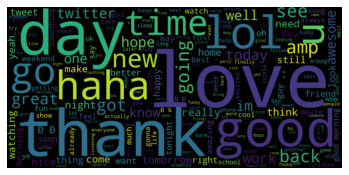

In [73]:
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [74]:
wordcloud = WordCloud(width = 1500, height = 720,
                background_color ='black',
                min_font_size = 10).generate(negative_preprocessed_text)

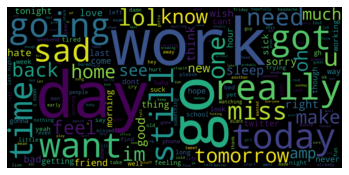

In [75]:
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

## b) Observations

# IV) Rule-Based Sentiment Analysis

## a) Retrieving Class Label for every instance

In [76]:
sid = SentimentIntensityAnalyzer()

In [77]:
def retrieve_label(y_pred, metric = "compound_with_neutral"):
    if metric == "compound_with_neutral":
        if y_pred["compound"] >= 0.05:
            label = 1
        elif y_pred["compound"] <= -0.05:
            label = 0
        else:
            label = -1
    elif metric == "compound_without_neutral":
        if y_pred["compound"] >= 0:
            label = 1
        else:
            label = 0
    elif metric == "neutral_mapped_to_pos_scores":
        if y_pred["neu"] >= y_pred["pos"] and y_pred["neu"] >= y_pred["neg"]:
            label = 1
        elif y_pred["pos"] >= y_pred["neg"]:
            label = 1
        else:
            label = 0
    elif metric == "neutral_mapped_to_neg_scores":
        if y_pred["neu"] >= y_pred["pos"] and y_pred["neu"] >= y_pred["neg"]:
            label = 0
        elif y_pred["pos"] >= y_pred["neg"]:
            label = 1
        else:
            label = 0
    elif metric == "pos_neg_scores":
        label = int(y_pred["pos"] >= y_pred["neg"])
    else:
        print(metric)
        raise ValueError("Use an appropriate metric from compound, pos_neg_neu_scores, pos_neg_scores")
    return label

### i) On preprocessed text

In [78]:
prptext_labels = []
for each_text in df_data["PREPROCESSED_TEXT"].values:
    sentiment_pred = sid.polarity_scores(each_text)
    prptext_labels.append(
        np.array(
            [
                retrieve_label(sentiment_pred, "compound_with_neutral"), 
                retrieve_label(sentiment_pred, "compound_without_neutral"), 
                retrieve_label(sentiment_pred, "neutral_mapped_to_pos_scores"),
                retrieve_label(sentiment_pred, "neutral_mapped_to_neg_scores"),
                retrieve_label(sentiment_pred, "pos_neg_scores")
            ]
        )
    )
prptext_labels = np.array(prptext_labels)

### ii) On raw text

In [79]:
rawtxt_labels = []
for each_text in df_data["TEXT"].values:
    sentiment_pred = sid.polarity_scores(each_text)
    rawtxt_labels.append(
        np.array(
            [
                retrieve_label(sentiment_pred, "compound_with_neutral"), 
                retrieve_label(sentiment_pred, "compound_without_neutral"), 
                retrieve_label(sentiment_pred, "neutral_mapped_to_pos_scores"),
                retrieve_label(sentiment_pred, "neutral_mapped_to_neg_scores"),
                retrieve_label(sentiment_pred, "pos_neg_scores")
            ]
        )
    )
rawtxt_labels = np.array(rawtxt_labels)

## b) Get accuracy scores

In [80]:
y = df_data["LABEL"].values

In [81]:
def get_accuracy(y_preds, y):
    no_instances = len(y)
    return 100*sum(y_preds==y)/no_instances

### i) Of preprocessed text

In [82]:
print("The accuracy score of labels calculated on the preprocessed text is:")
print("using the compound_with_neutral metric: ", get_accuracy(prptext_labels[:, 0], y))
print("using the compound_without_neutral metric: ", get_accuracy(prptext_labels[:, 1], y))
print("using the neutral_mapped_to_pos_scores metric: ", get_accuracy(prptext_labels[:, 2], y))
print("using the neutral_mapped_to_neg_scores metric: ", get_accuracy(prptext_labels[:, 3], y))
print("using the pos_neg_scores metric: ", get_accuracy(prptext_labels[:, 4], y))

The accuracy score of labels calculated on the preprocessed text is:
using the compound_with_neutral metric:  50.828084907860976
using the compound_without_neutral metric:  65.71028691392583
using the neutral_mapped_to_pos_scores metric:  58.385817588056916
using the neutral_mapped_to_neg_scores metric:  58.15255423372988
using the pos_neg_scores metric:  65.73361324935853


### ii) Of raw text

In [83]:
print("The accuracy score of labels calculated on the raw text is:")
print("using the compound_with_neutral metric: ", get_accuracy(rawtxt_labels[:, 0], y))
print("using the compound_without_neutral metric: ", get_accuracy(rawtxt_labels[:, 1], y))
print("using the neutral_mapped_to_pos_scores metric: ", get_accuracy(rawtxt_labels[:, 2], y))
print("using the neutral_mapped_to_neg_scores metric: ", get_accuracy(rawtxt_labels[:, 3], y))
print("using the pos_neg_scores metric: ", get_accuracy(rawtxt_labels[:, 4], y))

The accuracy score of labels calculated on the raw text is:
using the compound_with_neutral metric:  53.230697457429436
using the compound_without_neutral metric:  68.34616281782132
using the neutral_mapped_to_pos_scores metric:  55.28341497550735
using the neutral_mapped_to_neg_scores metric:  51.551201306274784
using the pos_neg_scores metric:  68.46279449498483
